# 1. Imports

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import GridSearchCV

# 2. Definições

In [35]:
IMAGES_PATH = "../reports/figures/images/"
PATH_INPUT_DATASET = "../data/processed/internacoes_processado.csv"

style_dict = {
    # "axes.grid": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": "large"
}

sns.set_theme(
    context="paper",
    style="ticks",
    palette="pastel",
    rc=style_dict
)

# 3. Funções de apoio

In [36]:

def salvar_figura(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def obter_nomes_colunas_por_tipo(df, numeric=False):
    if numeric:
        return list(df.select_dtypes(include=['int64', 'float64']).columns)
    else:
        return list(df.select_dtypes(include=['object']).columns)

def plotar_features_categoricas(df, target_column, categorical_features):
    for feature in categorical_features:
        sns.countplot(x=feature, data=df, hue=target_column)
        plt.show()
        plt.clf()
    plt.tight_layout()
    

# 4. Análise

In [37]:
df = pd.read_csv(PATH_INPUT_DATASET)

X = df.drop("reinternacao", axis=1)
y = df["reinternacao"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

df_train = X_train.merge(y_train, left_index=True, right_index=True)
df_test = X_test.merge(y_test, left_index=True, right_index=True)

## 4.1 Análise Univariada

# 4.1.1 Distribuições de Variáveis Categóricas

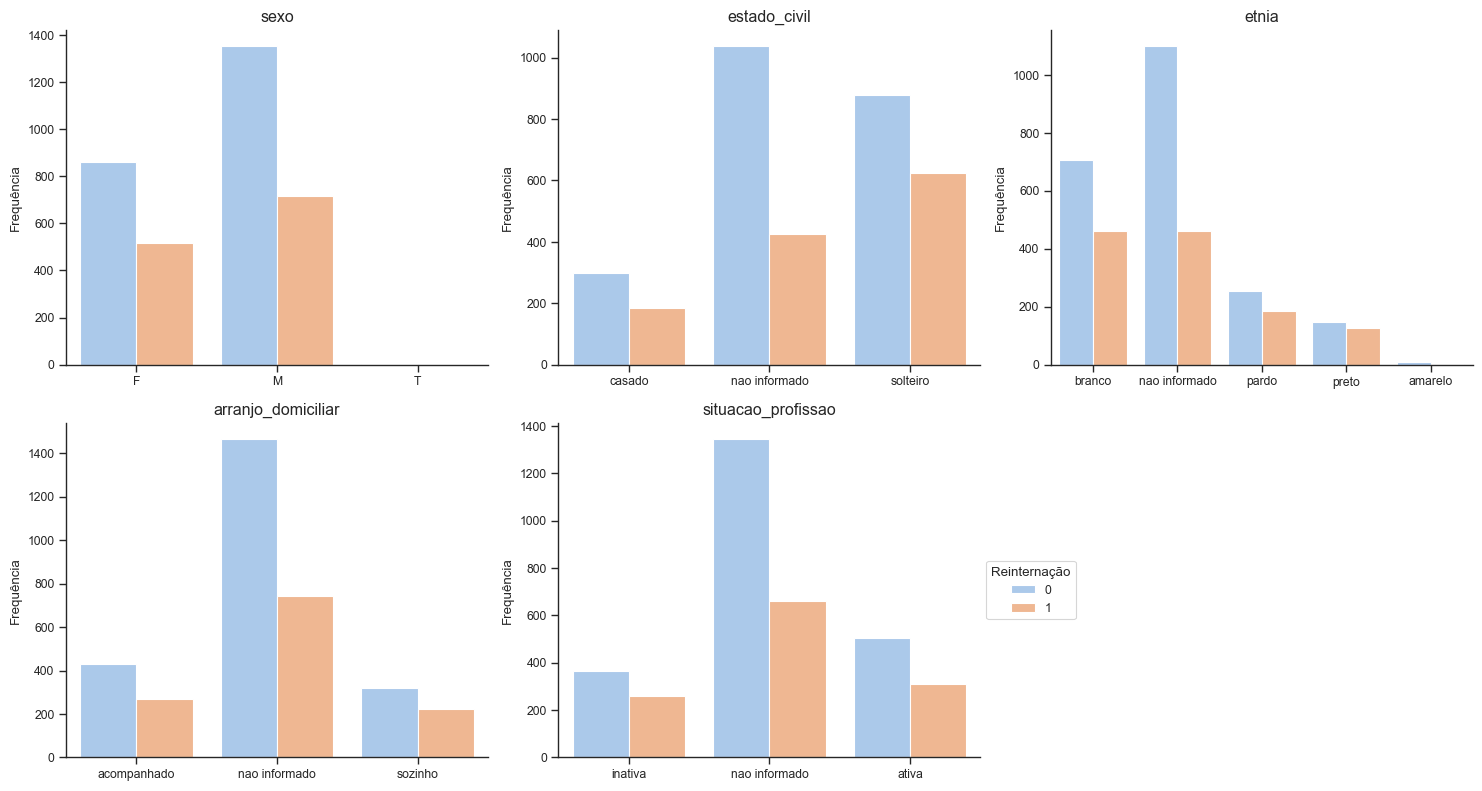

In [38]:
vars = ["sexo", "estado_civil", "etnia", "arranjo_domiciliar", "situacao_profissao"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for ax, var in zip(axes, vars):
    sns.countplot(x=var, data=df_train, ax=ax, hue="reinternacao")
    ax.set_title(var)
    ax.set_xlabel("")
    ax.set_ylabel("Frequência")
    ax.legend().remove()

plt.tight_layout()
axes[-1].axis("off")
axes[-2].legend(title="Reinternação", loc="center left", bbox_to_anchor=(1, 0.5));

# 5. Pipeline

## 5.1 Definição do preprocessor

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['idade_data_internacao', 'dia_semana_data_internacao', 'tempo_internacao_horas', 'idade_data_internacao', 'ano_data_internacao', 'mes_data_internacao']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sexo', 'estado_civil', 'etnia', 'arranjo_domiciliar', 'situacao_profissao', 'cid_diagnostico_grupo_chave'])
    ],
    remainder='passthrough'
)

## 5.2 Undersampling para balancear a variável resposta

In [41]:
print("Antes do undersampling:", Counter(y_train))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

print("Após o undersampling:", Counter(y_train_resampled))

Antes do undersampling: Counter({0: 2216, 1: 1233})
Após o undersampling: Counter({0: 1233, 1: 1233})


## 5.3 Definição dos modelos e hiperparâmetros

In [47]:
models = [
    ('RandomForest', RandomForestClassifier(), {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt'],
        'model__bootstrap': [True, False]
    }),
    ('GradientBoosting', GradientBoostingClassifier(), {
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['auto', 'sqrt']
    }),
    ('LogisticRegression', LogisticRegression(), {
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__max_iter': [100, 200, 300]
    }),
    ('XGB', XGBClassifier(), {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__min_child_weight': [1, 3, 5],
        'model__gamma': [0.0, 0.1, 0.2],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5, 1]
    }),
    ('LGBM', LGBMClassifier(), {
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__min_child_samples': [5, 10, 20],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__reg_alpha': [0, 0.1, 0.5, 1]
    }),    
]

## 5.4 Validação

In [48]:
results = {}
best_params_dict = {}
for model_name, model, params in models:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Configurando GridSearchCV para buscar os melhores hiperparâmetros
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring=['accuracy', 'roc_auc'], refit='accuracy', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)

    # Avaliando o desempenho do modelo com os melhores hiperparâmetros usando validação cruzada
    scores = grid_search.cv_results_['mean_test_accuracy']
    auc_scores = grid_search.cv_results_['mean_test_roc_auc']

    results[model_name] = scores[grid_search.best_index_]
    best_params_dict[model_name] = grid_search.best_params_

    # Imprimindo resultados
    print("-" * 80)
    print(f"{model_name}:")
    print(f"  Accuracy - {results[model_name]}")
    print(f"  AUC - {auc_scores.mean()}")
    print(f"  Best Parameters - {best_params_dict[model_name]}")

--------------------------------------------------------------------------------
RandomForest:
  Accuracy - 0.6228691560387941
  AUC - 0.650791664036214
  Best Parameters - {'model__bootstrap': True, 'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_leaf': 2, 'model__min_samples_split': 10, 'model__n_estimators': 200}
--------------------------------------------------------------------------------
GradientBoosting:
  Accuracy - 0.6252991270499544
  AUC - 0.6475728747727867
  Best Parameters - {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 150}
--------------------------------------------------------------------------------
LogisticRegression:
  Accuracy - 0.6163651444104097
  AUC - 0.6555030894711685
  Best Parameters - {'model__C': 1, 'model__max_iter': 100}
--------------------------------------------------------------------------------
XGB